# Eliminación de anomalías de la imagen
Este trabajo se ha realizado por los integrantes del grupo 18 Equipo 1 que son:
 - Rubén Rodríguez Hernández
 - Elena Murga Martinez
 - Mikel Aldalur Corta
 - David Caviedes Velasco
 
El integrante Jon Garí Galíndez no se ha puesto en contacto con el resto del grupo y no ha tomado parte en la practica del laboratorio.

## Explicacion del problema
La anomalía seleccionada es el __aliasing__. El aliasing se refiere a una interferencia producida por una disminución en la calidad de la imagen.

El efecto aliasing se produce cuando los píxeles (cantidad de píxeles) no pueden captar todos los detalles de la imagen (ya sea en detalles en una imagen estática o sus cambios durante el movimiento).

Por lo general cuando se adquiere una cámara se espera que la cantidad de píxeles sea suficiente para reproducir los detalles de una imagen, sin embargo, existen patrones de secuencias que tienen alta precisión y no llegan a ser suficientes los píxeles, en estos casos conviene cambiar la imagen por otra que tenga menos detalles. Los patrones más susceptibles para el aliasing son aquellos que contienen sucesiones de líneas paralelas separadas por la misma distancia. Cuanto más pequeña sea la separación entre las líneas, más evidente se hará el aliasing __[1]__.

Para poder disminuir el aliasing, se ha desarrollado una serie de funciones que actúan como __filtro antialiasing__. Su función es difuminar (menos nitidez) los patrones problemáticos para conservar la forma original y eliminar el defecto aliasing __[2]__.

También se ha visto que en las imágenes de blanco y negro que hemos adquirido, donde aparecen las letras, en caso de que la anomalía sea exagerada, tienen muchos píxeles que necesitan un cambio. Por ello se han realizado una serie de funciones para realizar el relleno de las esquinas que quedan con la interferencia del aliasing. Una vez hemos realizado el relleno de las esquinas, se realiza el filtro antialiasing mencionado anteriormente.

Para finalizar, hemos realizado una función (__desorden_imagen__) para diferenciar las imágenes planas de las imágenes más complejas. Ya que, como hemos mencionado anteriormente, en ciertas imágenes donde la anomalía es exagerada aplicamos una función de relleno a mayores del filtro antialiasing. El umbral que hemos usado para diferenciar unas imágenes de otras es 1.0%. Esto es debido a que los valores únicos en las imágenes planas es de casi dos órdenes de magnitud menor que el de las imágenes compejas.Y al evaluarlo frente al número total de píxeles de la imagen podemos observar que las planas no llegan al umbral mientras que las complejas lo sobrepasan.

## Librerías 
En primer lugar, se deben importar las librerías necesarias:
- numpy: para tratar con arrays.
- io de skimage: para tratar las imagenes normalizadas y en escala de grises en vez de RGB.

In [1]:
import numpy as np
from skimage import io

### Funciones
A continuación se definen las funciones creadas para equilibrar el efecto aliasing producido en algunas imágenes.

In [2]:
def antialiasing_filter(img):
    '''
    Función para aplicar filtro antialiasing en una imagen
    en función de los pixeles contiguos
    
    Parameters
    ----------
    img: numpy array (imagen a transformar)
    
    Returns
    -------
    res: numpy array (imagen transformada)
    '''
    res = np.zeros([img.shape[0], img.shape[1]])
    for i in range(img.shape[0]):
        for n in range(img.shape[1]):
            try: 
                # Media de pixels matriz 3x3 (pixel central = pixel de estudio)
                res[i,n] = (img[i-1,n-1] + img[i-1,n] + img[i-1,n+1] +
                            img[i,n-1] + img[i,n] + img[i,n+1] + 
                            img[i+1,n-1] + img[i+1,n] + img[i+1,n+1])/9.0
                # En caso de tratarse de un borde no se modifica su valor
            except:
                res[i,n] = img[i,n]
    
    return res

In [3]:
def desorden_imagen(imagen):
    '''
    Función para diferenciar imágenes planas de complejas: evaluación del 
    número de valores únicos frente al número de píxeles total de la imagen
    
    Parameters
    ----------
    imagen: numpy array (imagen a estudiar)
    
    Returns
    -------
    float (porcentaje de valores únicos vs. nº total de píxels)
    '''
    return (len(np.unique(imagen))/(imagen.shape[0]*imagen.shape[1])*100)

In [4]:
def rellenar (imagenSin, px, py, lx, ly, sumx, sumy, esq_lim_x, esq_lim_y):
    '''
    Función para aplicar relleno de esquinas en una imagen
    
    Parameters
    ----------
    imagenSin: numpy array (imagen a transformar)
    px,py: int (punto esquina para empezar el rellenado ejes x,y respectivamente)
    lx,ly: int (punto esquina para finalizar el rellenado eje x,y respectivamente)
    sumx,sumy: int (+1 o -1 segun en que cuadrante se encuentra la esquina eje x,y resp.)
    esq_lim_x,esq_lim_y: numpy float (largura de esquina máxima en ejes x,y / 2)
    
    Returns
    -------
    imagenSin: numpy array (imagen rellenada)
    '''
    try:
        #Estos números nos limitan el rellenado de esquinas demasiado grandes
        if((abs(px-lx) < esq_lim_x) and (abs(py-ly) < esq_lim_y)):
            # Miramos cuál de los ejes es más grande para realizar el rellenado en esa dirección
            if(abs(px-lx)<=abs(py-ly)):
                # Esta variable nos indica cuánto más debe de rellenar en cada pasada
                salto = (abs(px-lx) / abs(py-ly))
                # Realizar el relleno de esquinas
                while(np.floor(px)!=lx):
                    for i in range(py,ly,sumy):
                        imagenSin[i,int(np.floor(px))] = 0
                    px += salto*sumx
                    ly -= sumy
            elif(abs(px-lx)>abs(py-ly)):
                # Esta variable nos indica cuánto más debe de rellenar en cada pasada
                salto = (abs(py-ly) / abs(px-lx))
                # Realizar el rellenado de esquinas
                while(np.floor(py)!=ly):
                    for i in range(px,lx,sumx):
                        imagenSin[int(np.floor(py)),i] = 0
                    py += salto*sumy
                    lx -= sumx
    except:
        None
    return imagenSin

In [5]:
def puntosEsquina(imagen, px, py, sumx, sumy):
    '''
    Función para aplicar filtro antialiasing en una imagen
    en función de los pixeles contiguos
    
    Parameters
    ----------
    imagen: numpy array (imagen a transformar)
    px,py: int (punto esquina para empezar el rellenado en ejes x,y respectivamente)
    sumx,sumy: int (+1 o -1 segun en que cuadrante se encuentra la esquina, ejes x,y resp.)
    
    Returns
    -------
    punto_x,punto_y: int (esquina de la imagen ejes x,y respectivamente)
    '''
    lim = 50.0/255.0 # Valor límite para encontrar la esquina
    punto_x = px
    punto_y = py
    while(imagen[py,punto_x]<lim):
        punto_x += sumx
    while(imagen[punto_y,px]<lim):
        punto_y += sumy
    return punto_x, punto_y

In [6]:
def largoEsquinas(imagen,lim_s, lim_i):
    '''
    Función para detectar la largura de las esquinas
    
    Parameters
    ----------
    img: numpy array (imagen a transformar)
    lim_s: int (valor de limite superior para encontrar la esquina)
    lim_i: int (valor de limite inferior para encontrar la esquina)
    
    Returns
    -------
    longitudes_x: numpy array (largura de esquinas en eje x)
    longitudes_y: numpy array (largura de esquinas en eje y)
    '''
    s = imagen
    longitudes_x = []
    longitudes_y = []
    # Miramos la largura de todas las esquinas para que luego eliminemos las mas largas
    for i in range(s.shape[0]-1):
        for n in range(s.shape[1]-1):
            # 4º cuadrante  x positivo, y positivo
            if ((s[i-1,n-1] < lim_s) and (s[i-1,n] < lim_s) and (s[i,n-1] < lim_s) and (s[i,n] > lim_i)):
                esq_x, esq_y = puntosEsquina(s,n-1,i-1,1,1)
                longitudes_x.append(abs(n-esq_x))
                longitudes_y.append(abs(i-esq_y))
            # 3º cuadrante  x negativo y positivo    
            elif ((s[i-1,n+1] < lim_s) and (s[i-1,n] < lim_s) and (s[i,n+1] < lim_s) and (s[i,n] > lim_i)):
                esq_x, esq_y = puntosEsquina(s,n+1,i-1,-1,1)
                longitudes_x.append(abs(n-esq_x))
                longitudes_y.append(abs(i-esq_y))
            # 1º cuadrante  x positivo y negativo
            elif ((s[i+1,n-1] < lim_s) and (s[i+1,n] < lim_s) and (s[i,n-1] < lim_s) and (s[i,n] > lim_i)):
                esq_x, esq_y = puntosEsquina(s,n-1,i+1,1,-1)
                longitudes_x.append(abs(n-esq_x))
                longitudes_y.append(abs(i-esq_y))
            # 2º cuadrante  x negativo y negativo
            elif ((s[i+1,n+1] < lim_s) and (s[i+1,n] < lim_s)and (s[i,n+1] < lim_s) and (s[i,n] > lim_i)):
                esq_x, esq_y = puntosEsquina(s,n+1,i+1,-1,-1)
                longitudes_x.append(abs(n-esq_x))
                longitudes_y.append(abs(i-esq_y))

    return longitudes_x, longitudes_y

In [7]:
def rellenoEsquinas(imagen,lim_s, lim_i, arr_esq_lim_x, arr_esq_lim_y):
    '''
    Función para aplicar filtro antialiasing en una imagen
    en función de los pixeles contiguos
    
    Parameters
    ----------
    img: numpy array (imagen a transformar)
    lim_s: int (valor de limite superior para encontrar la esquina)
    lim_i: int (valor de limite inferior para encontrar la esquina)
    
    Returns
    -------
    res: numpy array (imagen transformada)
    '''
    s_re = np.ones([imagen.shape[0], imagen.shape[1]],dtype=np.uint8)
    s = imagen
    # Miraremos si existen esquinas que necesiten ser rellenadas, i es linea o eje y, n es columna o eje x
    for i in range(s.shape[0]-1):
        for n in range(s.shape[1]-1):
            # 4º cuadrante  x positivo, y positivo
            if ((s[i-1,n-1] < lim_s) and (s[i-1,n] < lim_s) and (s[i,n-1] < lim_s) and (s[i,n] > lim_i)):
                esq_x, esq_y = puntosEsquina(s,n-1,i-1,1,1)
                if not ((esq_x == n) or (esq_y == i)):
                    s_re = rellenar(s_re,n,i,esq_x-1, esq_y-1,1,1, np.max(arr_esq_lim_x)/2, np.max(arr_esq_lim_y)/2)
            # 3º cuadrante  x negativo y positivo    
            elif ((s[i-1,n+1] < lim_s) and (s[i-1,n] < lim_s) and (s[i,n+1] < lim_s) and (s[i,n] > lim_i)):
                esq_x, esq_y = puntosEsquina(s,n+1,i-1,-1,1)
                if not ((esq_x == n) or (esq_y == i)):
                    s_re = rellenar(s_re,n,i,esq_x+1, esq_y-1,-1,1, np.max(arr_esq_lim_x)/2, np.max(arr_esq_lim_y)/2)
            # 1º cuadrante  x positivo y negativo
            elif ((s[i+1,n-1] < lim_s) and (s[i+1,n] < lim_s) and (s[i,n-1] < lim_s) and (s[i,n] > lim_i)):
                esq_x, esq_y = puntosEsquina(s,n-1,i+1,1,-1)
                if not ((esq_x == n) or (esq_y == i)):
                    s_re = rellenar(s_re,n,i,esq_x-1, esq_y+1,1,-1, np.max(arr_esq_lim_x)/2, np.max(arr_esq_lim_y)/2)
            # 2º cuadrante  x negativo y negativo
            elif ((s[i+1,n+1] < lim_s) and (s[i+1,n] < lim_s)and (s[i,n+1] < lim_s) and (s[i,n] > lim_i)):
                esq_x, esq_y = puntosEsquina(s,n+1,i+1,-1,-1)
                if not ((esq_x == n) or (esq_y == i)):
                    s_re = rellenar(s_re,n,i,esq_x+1, esq_y+1,-1,-1, np.max(arr_esq_lim_x)/2, np.max(arr_esq_lim_y)/2)
    
    io.imshow(s_re)
    return s_re

In [8]:
def main_antialiasing(s):
    '''
    Función principal para eliminar el efecto aliasing de una imagen
    
    Parameters
    ----------
    s: numpy array (imagen a transformar --> normalizada y B&N)
    
    Returns
    -------
    res: numpy array (imagen filtrada)
    '''
    
    orden = desorden_imagen(s)
    if orden <= 1.0:
        limite_sup = 0.5
        limite_inf = 0.5
        larguras_x, larguras_y = largoEsquinas(s,limite_sup,limite_inf)
        img_1 = rellenoEsquinas(s,limite_sup, limite_inf, larguras_x, larguras_y)
        img_2 = np.where(img_1 < limite_inf, 0, s)
        s = img_2
    res = antialiasing_filter(s)
    return res

### Prueba imagen plana
Para esta primera prueba del algoritmo del filtro antialiasing se ha utilizado una imagen relativamente sencilla.

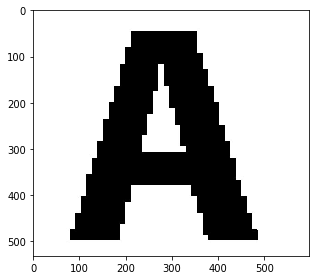

In [9]:
imagen = io.imread('Lab_1.jpg', as_gray = True)
io.imshow(imagen)

C:\Users\mikel\.conda\envs\Master_IA\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


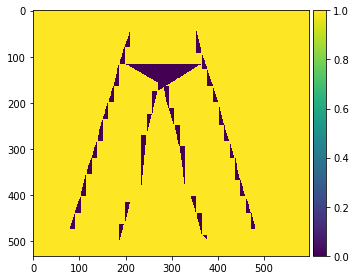

In [10]:
r = main_antialiasing(imagen)

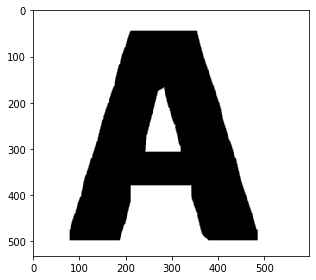

In [11]:
io.imshow(r)

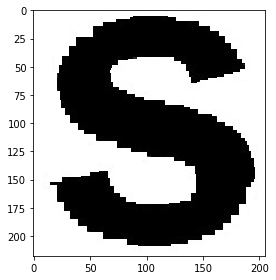

In [12]:
imagen = io.imread('s_1.jpg', as_gray = True)
io.imshow(imagen)

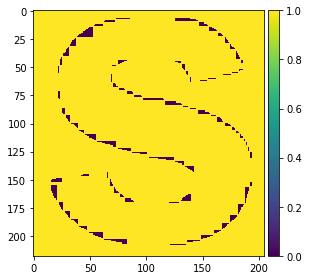

In [13]:
r = main_antialiasing(imagen)

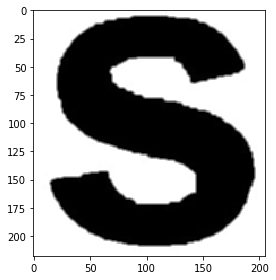

In [14]:
io.imshow(r)

### Prueba imagen compleja
Como segunda prueba, ha utilizado una imagen algo más compleja para comprobar que los resultados tambien puedes ser buenos en las imagenes mas complejas.

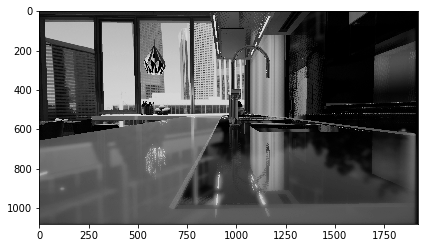

In [15]:
imagen = io.imread('2.jpg', as_gray = True)
io.imshow(imagen)

In [16]:
r = main_antialiasing(imagen)

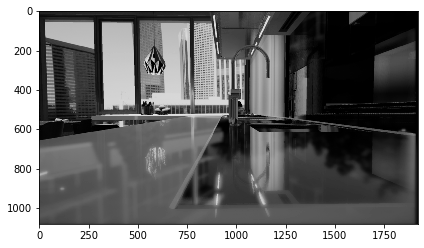

In [17]:
io.imshow(r)

## Referencias
__[1]__ Mañana Guichón, G. (1993). Algoritmos de antialiasing. Ingeniería e Investigación.

__[2]__ https://github.com/rougier/python-opengl/blob/master/06-anti-grain.rst